In [ ]:
# This notebook contains the code to plot the posterior distribution of the difference between geometry and growth parameter 
# duplicates (Fig. 4) and to calculate the significance.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from chainconsumer import ChainConsumer
import os
import glob
import anesthetic
from scipy.stats import gaussian_kde

In [2]:
def loadMontePythonChain(directory, two_cosmo = False, params_out = None, params_out_diff = None):
    # load data
    data = np.loadtxt(directory + '/chain_NS__accepted.txt')
    # load parameter names
    filename = glob.glob(directory+'/*.paramnames')
    names = np.loadtxt(filename[0], dtype = str, delimiter='\t').T[0]
#     names = np.loadtxt(directory + '/chain.paramnames', dtype=str, delimiter='\t').T[0]
    names = np.concatenate((['weight','mloglkl'], names))
    # remove trailing spaces
    for idx, name in enumerate(names):
        if name[-1] == ' ':
            names[idx] = name[:-1]
    if two_cosmo == True:
        dataframe = pd.DataFrame(data, columns = names)
        # List of parameters that appear in the 2cosmo chain. Note: Each parameter appears twice!
        if 'delta_c' in names:
            params = ['weight','mloglkl', 'omega_cdm', 'S_8', 'omega_b', 'n_s', 'h', 'A_IA', 'c_min', 'D_z1', 'D_z2', 'D_z3', 'D_z4', 'D_z5', 'delta_c', 'Omega_m', 'sigma8']
        else:
            params = ['weight','mloglkl', 'omega_cdm', 'S_8', 'omega_b', 'n_s', 'h', 'A_IA', 'c_min', 'D_z1', 'D_z2', 'D_z3', 'D_z4', 'D_z5', 'Omega_m', 'sigma8']
#         Set up dataframes for both sets of cosmological parameters and for the difference between them
        chain1 = np.zeros((dataframe.shape[0],len(params)))
        chain2 = np.zeros((dataframe.shape[0],len(params)))
        diff = np.zeros((dataframe.shape[0],len(params)))
        for idx, param in enumerate(params):
            # two first two columns contain the weight and mlogkl.
            if idx <2:
                chain1[:,idx] = dataframe[param]
                chain2[:,idx] = dataframe[param]
                diff[:,idx] = dataframe[param]
            else:
                # Copy data of both sets of cosmological parameters to the respective dataframe and calculate the difference
                if param == 'omega_m':
                    # calculate omega_m from Omega_m and h
                    chain1[:,idx] = dataframe['Omega_m_1'] * (dataframe['Omega_m_1']/0.3)**0.5
                    chain2[:,idx] = dataframe['Omega_m_2'] * (dataframe['Omega_m_2']/0.3)**0.5
                    diff[:,idx] = dataframe['Omega_m_1'] * (dataframe['Omega_m_1']/0.3)**0.5 - dataframe['sigma8_2'] * (dataframe['Omega_m_2']/0.3)**0.5
                elif param in ['A_IA', 'c_min', 'D_z1', 'D_z2', 'D_z3', 'D_z4', 'D_z5', 'delta_c']:
                    chain1[:,idx] = dataframe[param]
                    chain2[:,idx] = dataframe[param]
                else:
                    chain1[:,idx] = dataframe[param+'_1']
                    chain2[:,idx] = dataframe[param+'_2']
                    diff[:,idx] = dataframe[param+'_1'] - dataframe[param+'_2']
        if params_out:
            chain1 = pd.DataFrame(chain1, columns = params_out)
            chain2 = pd.DataFrame(chain2, columns = params_out)
        else:
            chain1 = pd.DataFrame(chain1, columns = params)
            chain2 = pd.DataFrame(chain2, columns = params)
        if params_out_diff:
            diff = pd.DataFrame(diff, columns = params_out_diff)
        else:
            diff = pd.DataFrame(diff, columns = params)
        return(chain1,chain2,diff)
    else:
        if params_out:
            chain = pd.DataFrame(data, columns = params_out)
        else:
            chain = pd.DataFrame(data, columns = names)
        return(chain)

def loadMontePythonChain_bf(directory, params_out):
    data = np.loadtxt(directory + '/chain_NS__accepted.txt')
    # load parameter names
    filename =  glob.glob(directory + '/*.paramnames')
    names = np.loadtxt(filename[0], dtype=str, delimiter='\t').T[0]
    # first two columns: weight & mloglkl
    params = np.concatenate((['weight','mloglkl'], names))
    # remove trailing spaces
    for idx, name in enumerate(params):
        if name[-1] == ' ':
            params[idx] = name[:-1]
    if params_out:
        chain = pd.DataFrame(data, columns = params_out)
    else:
        chain = pd.DataFrame(data, columns = params)
    # add the true chi2 to the chain
    chain.insert(2,'chi2',2*chain['mloglkl'])
    return(chain)
def plots(directory, cols, cols_diff, results_folder, params_out = None, params_out_diff = None, extents = None, extents_diff = None):
    chain1, chain2, diff = loadMontePythonChain('%s'%(directory), two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
    c = ChainConsumer()
    c.add_chain(chain2[cols], weights=chain2['weight'], name = 'geometry', color='o',kde=1.5,shade=True,shade_alpha=0.6)
    c.add_chain(chain1[cols], weights=chain1['weight'], name = 'growth', color='b',kde=1.5,shade=True,shade_alpha=0.6)

    c.configure(plot_hists=True,shade_gradient=1.0,diagonal_tick_labels=True,label_font_size=14,tick_font_size=13,serif=True,legend_color_text=True,linewidths=1.5,statistics="max")
    c.plotter.plot(filename='%s_joint_chain.pdf'%(results_folder),figsize=1.5, extents=extents)
    plt.close()
    c = ChainConsumer()
    c.add_chain(diff[cols_diff], weights = diff['weight'], color='b',kde=1.5,shade=True,shade_alpha=0.6)
    c.configure(plot_hists=True,shade_gradient=1.0,diagonal_tick_labels=True,label_font_size=14,tick_font_size=13,serif=True,legend_color_text=True,linewidths=1.5,statistics="max")
    c.plotter.plot(filename='%s_diffs.pdf'%(results_folder),figsize=1.5,truth=[0,0,0,0,0,0,0], extents=extents_diff)
    plt.close()
def plots_1c(directory, cols, results_folder, params_out = None, extents = None):
    chain1 = loadMontePythonChain('%s'%(directory), two_cosmo = False, params_out=params_out)
    c = ChainConsumer()
    c.add_chain(chain1[cols], weights=chain1['weight'], name = 'growth', color='b',kde=1.5,shade=True,shade_alpha=0.6)
    c.configure(plot_hists=True,shade_gradient=1.0,diagonal_tick_labels=True,label_font_size=14,tick_font_size=13,serif=True,legend_color_text=True,linewidths=1.5,statistics="max")
    c.plotter.plot(filename='%s.pdf'%(results_folder),figsize=1.5, extents=extents)
    plt.close()
def plots_shared(directory, cols, cols_diff, results_folder, params_out = None, params_out_diff = None, extents = None, extents_diff = None):
    chain1, chain2, diff = loadMontePythonChain('%s'%(directory), two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
    c = ChainConsumer()
    c.add_chain(chain2[cols], weights=chain2['weight'], name = 'shared parameters', color='o',kde=1.5,shade=True,shade_alpha=0.6)
    c.configure(plot_hists=True,shade_gradient=1.0,diagonal_tick_labels=True,label_font_size=14,tick_font_size=13,serif=True,legend_color_text=True,linewidths=1.5,statistics="max")
    c.plotter.plot(filename='%s_shared.pdf'%(results_folder),figsize=1.5, extents=extents)
    plt.close()
def calculate_significance(directory,key_params=[]):
    chain1, chain2, diff = loadMontePythonChain('%s'%(directory), two_cosmo = True)
    # set up an array og sigma levels
    sigma_lvls = np.arange(0., 10.01, 0.001)
    # determine confidence regions for each sigma value
    # chi2.sf: Survival function (also defined as 1 - cdf, but sf is sometimes more accurate)
    conf_int = np.array([scipy.stats.chi2.sf(s**2, 1) for s in sigma_lvls])
    get_sigma_lvl = scipy.interpolate.interp1d(conf_int, sigma_lvls, kind='linear')
    sigma = np.zeros(len(key_params))
    for idx_params, params in enumerate(key_params):
        # Weighted Gaussian KDE of the posterior distribution of parameter differences
        Gaussian_wKDE = scipy.stats.gaussian_kde(diff[params].T, weights=diff['weight'])
        # Evaluate the Gaussian KDE at the origin
        thresh = Gaussian_wKDE.evaluate(np.zeros(len(params)))
        full_sum_below = 0.
        densities = Gaussian_wKDE.evaluate(diff[params].values.T)
        for idx in range(diff[params].shape[0]):
            if densities[idx] <= thresh:
                full_sum_below += diff['weight'][idx]
        full_sum_below /= diff['weight'].sum()
        # Infer the sigma level
        sigma[idx_params] = get_sigma_lvl(full_sum_below)
    return(sigma)

In [3]:
##################################################################################################################################
# Calculate significance of the differences between the marginalised distributions of the duplicated parameters, shown in Fig. 4:
# See arXiv:1809.01406
directory = '../chains/'
chains = ['K1K_bp', 'K1K_Cl', 'K1K_ClLy','K1K_ClLyC']
# supply subspaces for which you want to calculate significances:
#all_key_params = [['S_8', 'Omega_m', 'h'], ['S_8', 'Omega_m'], ['h', 'Omega_m'], ['S_8', 'h'],['S_8'],['Omega_m'],['h']]
all_key_params = [['S_8', 'Omega_m'], ['h', 'Omega_m'], ['S_8', 'h']]
header = 'data split, '
sigmas = np.zeros((len(chains), len(all_key_params)))
for idx, chain in enumerate(chains):
    print('Calculating significances for: %s'%chain)
    sigmas[idx, :] = calculate_significance(directory+chain, key_params=all_key_params)
    # Set up header and column names
    description = chains
#     description = ['z-bin %s vs. all others'%zbin for zbin in range(1,6)]
savedata = np.column_stack((np.asarray(description), np.around(sigmas,2)))
# manually add $ and \sigma to get a nice latex table
for i in range(len(chains)):
    for j in range(1,len(all_key_params)+1):
        savedata[i,j] = r'$%s \sigma$'%savedata[i,j]
# header = ['dataset',r'$\Delta(S_8, \Omega_{\rm m, h)$',r'$\Delta(S_8,\Omega_{\rm m})$', r'$\Delta(h,\Omega_{\rm m})$', r'$\Delta(S_8,h)$', r'$\Delta(S_8)$', r'$\Delta(\Omega_{\rm m})$',r'$\Delta(h)$']
header = ['dataset',r'$\Delta(S_8,\Omega_{\rm m})$', r'$\Delta(h,\Omega_{\rm m})$', r'$\Delta(S_8,h)$']
df = pd.DataFrame(data = savedata, columns = header)
df

Calculating significances for: K1K_bp
Calculating significances for: K1K_Cl
Calculating significances for: K1K_ClLy
Calculating significances for: K1K_ClLyC


,dataset,"$\Delta(S_8,\Omega_{\rm m})$","$\Delta(h,\Omega_{\rm m})$","$\Delta(S_8,h)$"
0,K1K_bp,$0.01 \sigma$,$0.03 \sigma$,$0.01 \sigma$
1,K1K_Cl,$0.64 \sigma$,$1.27 \sigma$,$0.25 \sigma$
2,K1K_ClLy,$0.35 \sigma$,$0.72 \sigma$,$0.11 \sigma$
3,K1K_ClLyC,$0.57 \sigma$,$0.37 \sigma$,$0.01 \sigma$


In [4]:
# load the chains
params_out = ['weight','mloglkl',r'$\omega_{\rm cdm}$', r'$S_8$', r'$\omega_{\rm b}$', r'$n_{\rm s}$', r'$h$', r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$', r'$\Omega_{\rm m}$', r'$\sigma_8$']
params_out_diff = ['weight','mloglkl',r'$\Delta \omega_{\rm cdm}$', r'$\Delta S_8$', r'$\Delta \omega_{\rm b}$', r'$\Delta n_{\rm s}$', '$\Delta h$', r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$', r'$\Delta \Omega_{\rm m}$', r'$\Delta \sigma_8$']
K1K = loadMontePythonChain('../chains/K1K_bp/', two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
K1K_Cl = loadMontePythonChain('../chains/K1K_Cl/', two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
K1K_ClLy = loadMontePythonChain('../chains/K1K_ClLy/', two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
K1K_ClLyC = loadMontePythonChain('../chains/K1K_ClLyC/', two_cosmo = True, params_out=params_out, params_out_diff=params_out_diff)
cols_diff = [r'$\Delta \Omega_{\rm m}$', r'$\Delta S_8$', '$\Delta h$']
# Each chain contains 3 Pandas dataframes
# 1) Cosmo 1
# 2) Cosmo 2
# 3) Difference: cosmo1 - cosmo2
# For example K1K[2] returns the chain that contains the difference between geo and growth

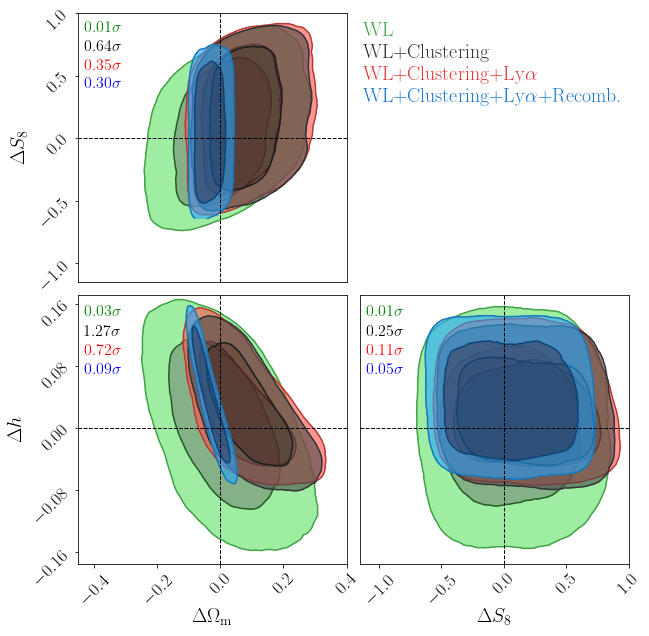

In [5]:
c = ChainConsumer()
c.add_chain(K1K[2][cols_diff], weights = K1K[2]['weight'], color='g',kde=1.5,shade=True,shade_alpha=0.6, name = 'WL', zorder = 1)
c.add_chain(K1K_Cl[2][cols_diff], weights = K1K_Cl[2]['weight'], color='k',kde=1.5,shade=True,shade_alpha=0.6, name = 'WL+Clustering', zorder = 3)
c.add_chain(K1K_ClLy[2][cols_diff], weights = K1K_ClLy[2]['weight'], color='r',kde=1.5,shade=True,shade_alpha=0.6, name = r'WL+Clustering+Ly$\alpha$', zorder = 2)
c.add_chain(K1K_ClLyC[2][cols_diff], weights = K1K_ClLyC[2]['weight'], color='b',kde=1.5,shade=True,shade_alpha=0.6, name = r'WL+Clustering+Ly$\alpha$+Recomb.', zorder = 4)
c.configure(plot_hists=False,shade_gradient=1.0,diagonal_tick_labels=True,label_font_size=20,tick_font_size=18,serif=True,legend_color_text=True,linewidths=1.5)
fig = c.plotter.plot(figsize=2.0,truth=[0,0,0], extents = {cols_diff[0]:(-0.45,0.4), cols_diff[1]:(-1.15,1)})
fig.axes[0].annotate(r'$0.01\sigma$', (-0.43,0.85), size = 16, zorder = 5, color = "g")
fig.axes[0].annotate(r'$0.64\sigma$', (-0.43,0.7), size = 16, zorder = 5, color = "k")
fig.axes[0].annotate(r'$0.35\sigma$', (-0.43,0.55), size = 16, zorder = 5, color = "r")
fig.axes[0].annotate(r'$0.30\sigma$', (-0.43,0.4), size = 16, zorder = 5, color = "b")

fig.axes[2].annotate(r'$0.03\sigma$', (-0.43,0.145), size = 16, zorder = 5, color = "g")
fig.axes[2].annotate(r'$1.27\sigma$', (-0.43,0.12), size = 16, zorder = 5, color = "k")
fig.axes[2].annotate(r'$0.72\sigma$', (-0.43,0.095), size = 16, zorder = 5, color = "r")
fig.axes[2].annotate(r'$0.09\sigma$', (-0.43,0.07), size = 16, zorder = 5, color = "b")

fig.axes[3].annotate(r'$0.01\sigma$', (-1.1,0.145), size = 16, zorder = 5, color = "g")
fig.axes[3].annotate(r'$0.25\sigma$', (-1.1,0.12), size = 16, zorder = 5, color = "k")
fig.axes[3].annotate(r'$0.11\sigma$', (-1.1,0.095), size = 16, zorder = 5, color = "r")
fig.axes[3].annotate(r'$0.05\sigma$', (-1.1,0.07), size = 16, zorder = 5, color = "b")

# plt.savefig('/mnt/c/Users/Jaime/Desktop/paper_plots/diffs.pdf')
plt.show()

In [ ]:
# More plotting scipts. Note: These are NOT the plots that are shown in the paper.

In [ ]:
# Plot BandPowers chains
directory = '../chains/'
results_folder = ''
# chains = ['K1K_Cl']#'K1K_bp']#, 'K1K_clustering', 'K1K_clustering_lya']
# chains = ['K1K_bp','K1K_Cl','K1K_ClLy','K1K_ClLyC']
chains = ['K1K_ClLyC']
############################################################################
# Plot marginalised posterior distributions of the duplicated parameters:
#
# Set up column names of pandas dataframes (optional)
params_out = ['weight','mloglkl',r'$\omega_{\rm cdm}$', r'$S_8$', r'$\omega_{\rm b}$', r'$n_{\rm s}$', r'$h$', r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$', r'$\Omega_{\rm m}$', r'$\sigma_8$']
params_out_diff = ['weight','mloglkl',r'$\Delta \omega_{\rm cdm}$', r'$\Delta S_8$', r'$\Delta \omega_{\rm b}$', r'$\Delta n_{\rm s}$', '$\Delta h$', r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$', r'$\Delta \Omega_{\rm m}$', r'$\Delta \sigma_8$']
# List of parameters to plot:
cols = [r'$\omega_{\rm b}$', r'$\omega_{\rm cdm}$',r'$\Omega_{\rm m}$', r'$S_8$', r'$\sigma_8$', r'$n_{\rm s}$', r'$h$']
cols_diff = [r'$\Delta \omega_{\rm b}$', r'$\Delta \omega_{\rm cdm}$',r'$\Delta \Omega_{\rm m}$', r'$\Delta S_8$', r'$\Delta \sigma_8$', r'$\Delta n_{\rm s}$', '$\Delta h$'] 
for chain in chains:
    plots(directory+chain, cols, cols_diff, results_folder+chain, params_out, params_out_diff)

In [ ]:
# Plot posteriors of shared parameters
directory = '../chains/'
chains = ['K1K_bp','K1K_Cl','K1K_ClLy','K1K_ClLyC']
params_out = ['weight','mloglkl',r'$\omega_{\rm cdm}$', r'$S_8$', r'$\omega_{\rm b}$', r'$n_{\rm s}$', r'$h$', r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$', r'$\Omega_{\rm m}$', r'$\sigma_8$']
cols_shared = [r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$']
for chain in chains:
    plots_shared(directory+chain, cols_shared, cols_diff, results_folder+chain, params_out)

In [ ]:
# Plot 1cosmo chains
directory = '../chains/'
chains = ['K1K_Ly_1c']
# chains = ['K1K_Cl_1c','K1K_ClLy_1c','K1K_ClLyC_1c']

############################################################################
# Plot marginalised posterior distributions of the duplicated parameters:
#
# Set up column names of pandas dataframes (optional)
params_out = ['weight','mloglkl',r'$\omega_{\rm cdm}$', r'$S_8$', r'$\omega_{\rm b}$', r'$n_{\rm s}$', r'$h$', r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$', r'$\Omega_{\rm m}$', r'$\sigma_8$']
# List of parameters to plot:
cols = [r'$\omega_{\rm b}$', r'$\omega_{\rm cdm}$',r'$\Omega_{\rm m}$', r'$S_8$', r'$\sigma_8$', r'$n_{\rm s}$', r'$h$']
for chain in chains:
    plots_1c(directory+chain, cols, results_folder+chain, params_out)

In [ ]:
# Plot 1cosmo nuisance
directory = '../chains/'
results_folder = 'nuisance_'
# chains = ['K1K_1c']
chains = ['K1K_1c']#, 'K1K_Cl_1c','K1K_ClLy_1c','K1K_ClLyC_1c']

############################################################################
# Plot marginalised posterior distributions of the duplicated parameters:
#
# Set up column names of pandas dataframes (optional)
params_out = ['weight','mloglkl',r'$\omega_{\rm cdm}$', r'$S_8$', r'$\omega_{\rm b}$', r'$n_{\rm s}$', r'$h$', r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$', r'$\Omega_{\rm m}$', r'$\sigma_8$']
# List of parameters to plot:
cols = [r'$A_{\rm IA}$', r'$c_{\rm min}$',r'$\delta z_1$', r'$\delta z_2$', r'$\delta z_3$', r'$\delta z_4$', r'$\delta z_5$']
for chain in chains:
    plots_1c(directory+chain, cols, results_folder+chain, params_out)